# Vehicle detection using cv
Detect vehicles from camera image using cv

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time
from sklearn.externals import joblib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from VehicleFinder import *
from moviepy.editor import VideoFileClip

## Load data

In [2]:
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')
test_image = glob.glob('./test_images/*.jpg')

print('training data size cars: {} non-cars: {}'.format(len(cars), len(notcars)))

training data size cars: 8792 non-cars: 8968


In [37]:
img = mpimg.imread(cars[10])
#img = img * 255
cvt_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
print(np.min(cvt_img[..., 0]), np.min(cvt_img[..., 1]), np.min(cvt_img[..., 2]))
print(np.max(cvt_img[..., 0]), np.max(cvt_img[..., 1]), np.max(cvt_img[..., 2]))

0.0844588 0.429391 0.452993
0.672984 0.526023 0.532896


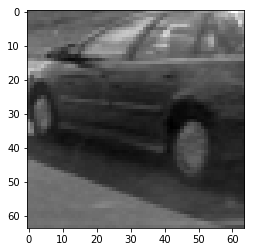

In [40]:
plt.imshow(cvt_img[..., 0], 'gray')
plt.show()

In [15]:
# visualize few samples
def show_samples_path(path_list, number=10):
    f, axs = plt.subplots(number // 5, 5, figsize=(20,number))    
    show_list = random.sample(path_list, number)
    for i in range(number):
        img = mpimg.imread(show_list[i])
        axs[i//5, i % 5].imshow(img)
    plt.show()

### Let's check how train data looks like

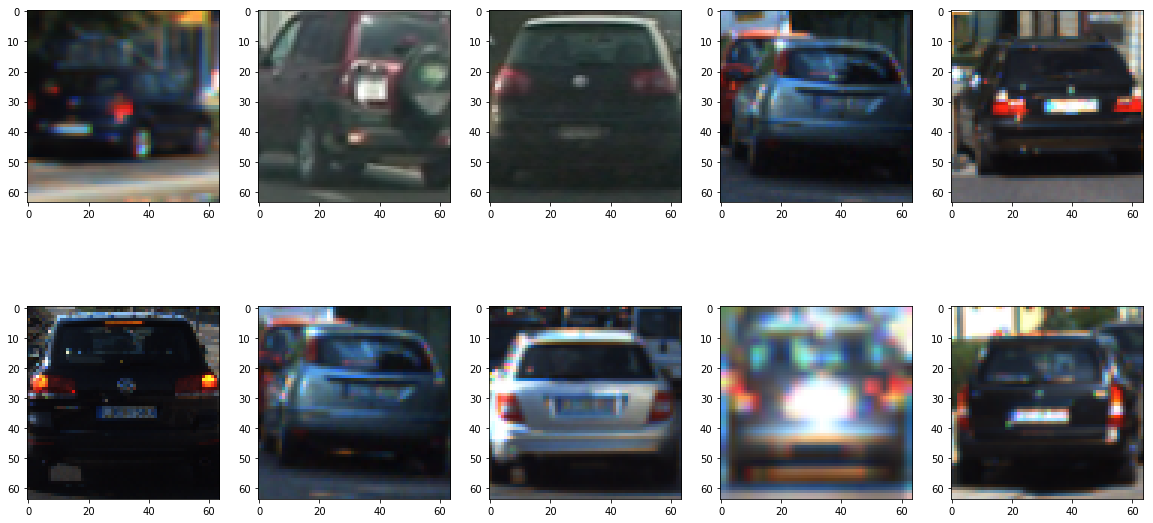

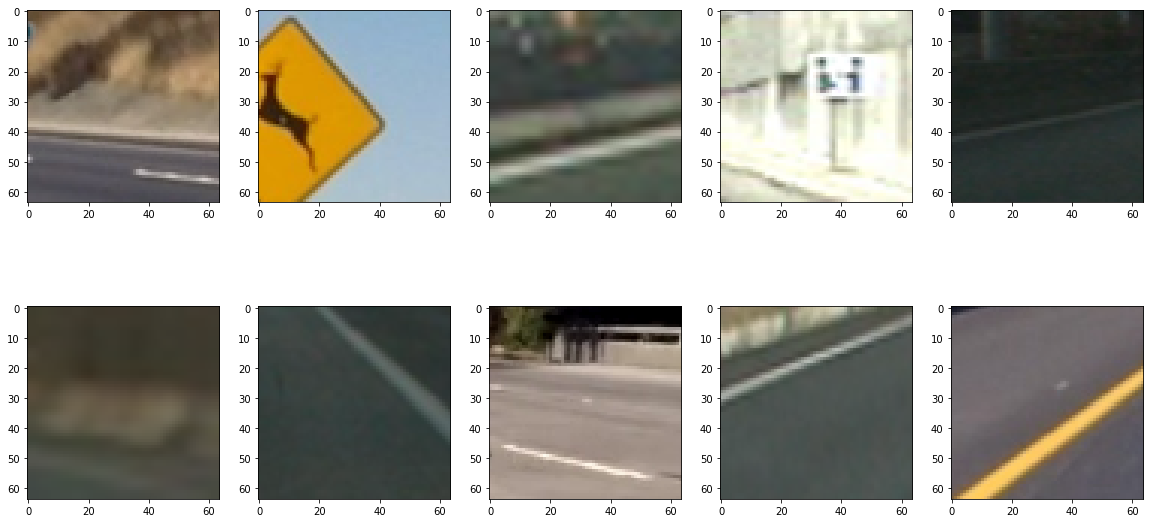

In [16]:
show_samples_path(cars, 10)
show_samples_path(notcars, 10)

## train data
### let's first visualize feature extraction

In [3]:
finder = VehicleFinder(color_space='YCrCb', spatial_size=(32,32), hist_nbins=32, hist_bins_range=(0,1.0), 
                       hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, channel=0)

In [4]:
car_features = finder.feature_extraction_from_path(cars)
notcar_features = finder.feature_extraction_from_path(notcars)

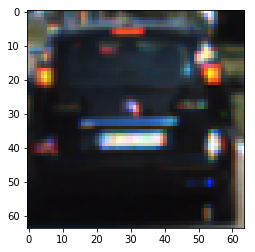

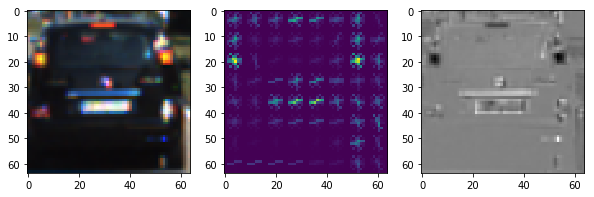

In [36]:
img = mpimg.imread(cars[1514])
plt.imshow(img)
img_cvt = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
feature, hog_img = get_hog(img_cvt[...,2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, ravel=True)
ax1.imshow(img)
ax2.imshow(hog_img)
ax3.imshow(img_cvt[..., 2], 'gray')
plt.show()

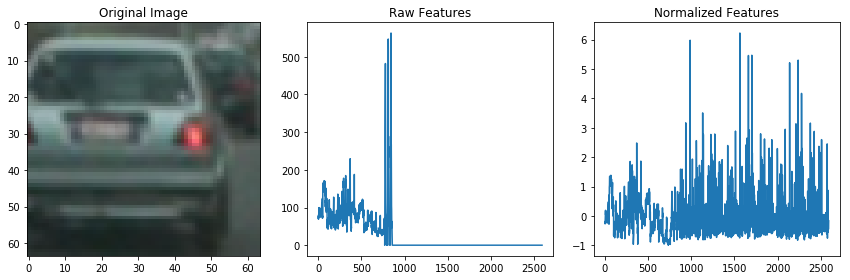

In [19]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

### Visualize hog features

In [18]:
def visualize_hog(path_list, number):
    for i in np.random.choice(100, number, replace=False):
        img = mpimg.imread(path_list[i])
        img_cvt = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
        feature, hog_img = get_hog(img_cvt[...,0], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, ravel=False)
        ax1.imshow(img)
        ax2.imshow(hog_img)
        ax3.imshow(img_cvt[..., 0], 'gray')
        plt.show()

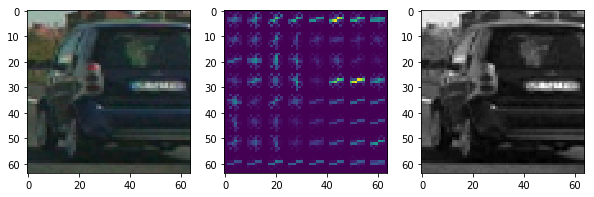

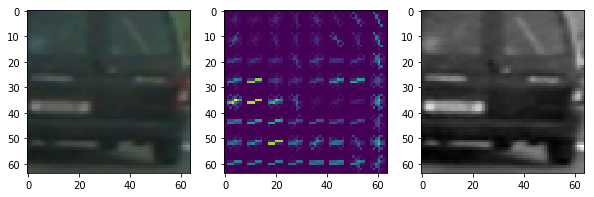

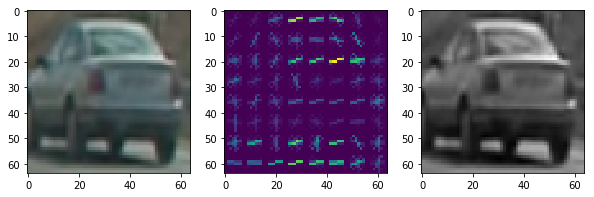

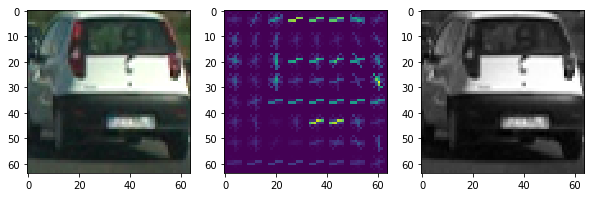

In [19]:
visualize_hog(cars, 4)

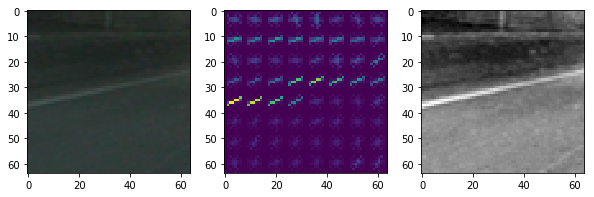

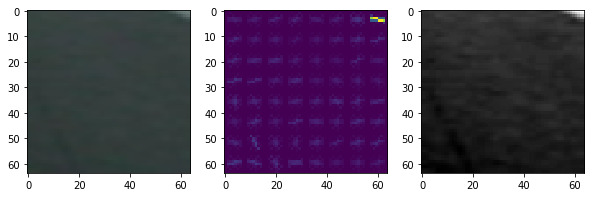

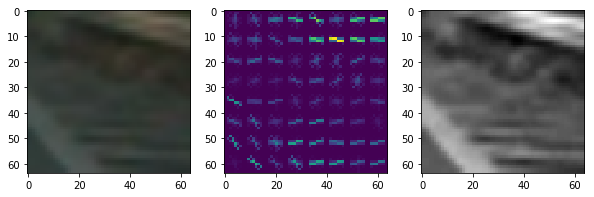

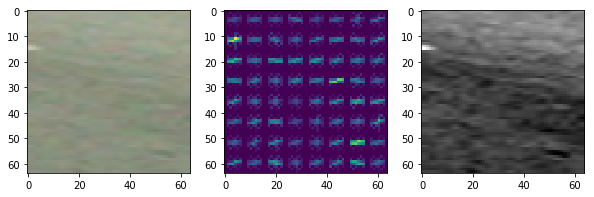

In [11]:
visualize_hog(notcars, 4)

### Create finder instance and train the data

In [4]:
finder.train_from_path(cars, notcars)
joblib.dump(finder, './finder')
joblib.dump(finder.clf, './clf')
joblib.dump(finder.scaler, './scaler')

13.9 sec to train SVC
Test accuracy of SVC: 0.9814
Predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
Truth:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.00186 sec to predict 10 samples
feature vector size:  4932


['./scaler']

### or load pre-trained finder

In [4]:
# for loading pre-trained classifier
#finder = joblib.load('./finder')
finder.clf = joblib.load('./clf')
finder.scaler = joblib.load('./scaler')

### Test classifier on example images
* Apply hog-subsampling for efficiency.
* Apply Search windows with varying sizes
* Create heatmap from positive boxes and create heatmap from it.
* visualize the result

In [9]:
%load_ext line_profiler

In [45]:
def image_test(verbose=False):
    t1 = time.time()
    for img_path in test_image:
        image = mpimg.imread(img_path)
        boxes1 = finder.find_cars_from_img(image, 400, 600, .7)        
        boxes2 = finder.find_cars_from_img(image, 380, 480, 1.1)
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        #heatmap = cal_heatmap(heatmap, boxes1)
        boxes1.extend(boxes2)
        #boxes1.extend(boxes3)
        heatmap = cal_heatmap(heatmap, boxes1)
        heatmap = apply_threshold(heatmap, 1)
        label_boxes = labeled_heat_boxes(heatmap)
        
        if verbose is True:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
            ax1.imshow(draw_boxes(image, label_boxes))
            hot = ax2.imshow(heatmap, cmap='hot', clim=[0, 10])

            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(hot, cax=cax)
            plt.show()
    t2 = time.time()
    print('Prediction time for {} images: {}'.format(len(test_image), round(t2 - t1, 2)))

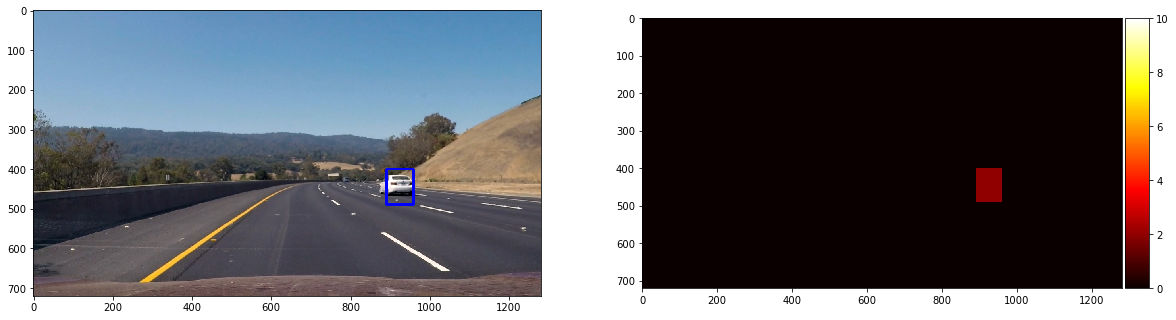

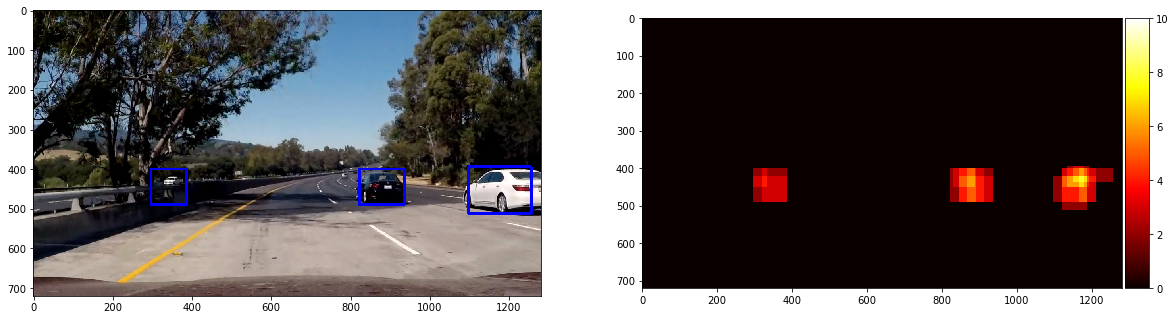

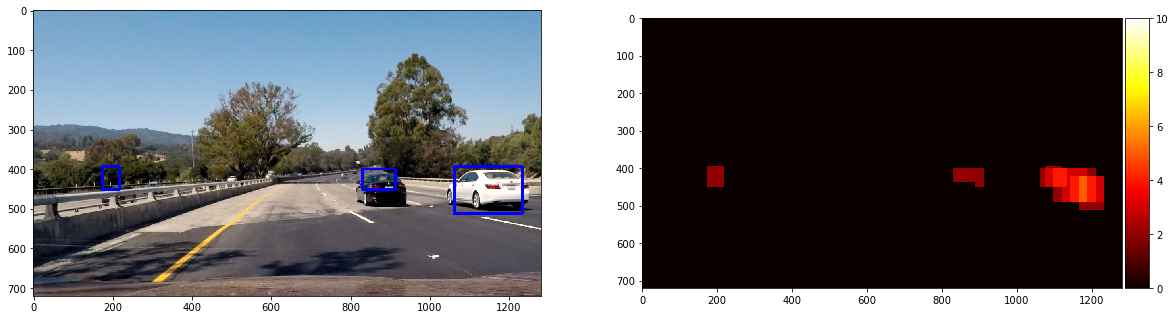

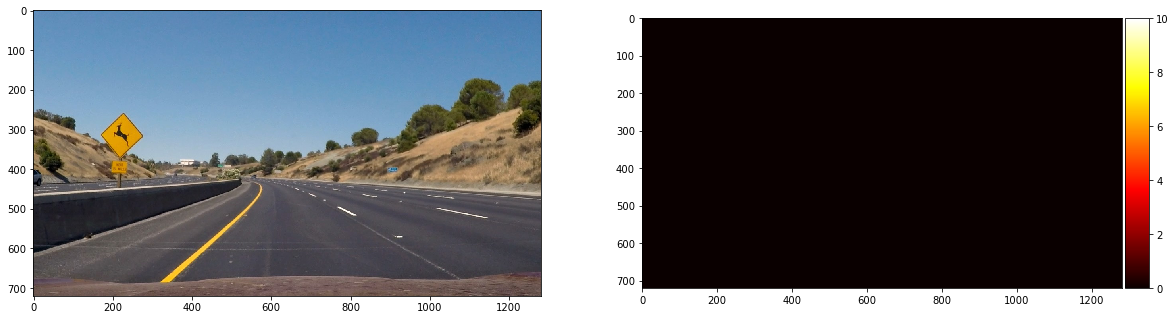

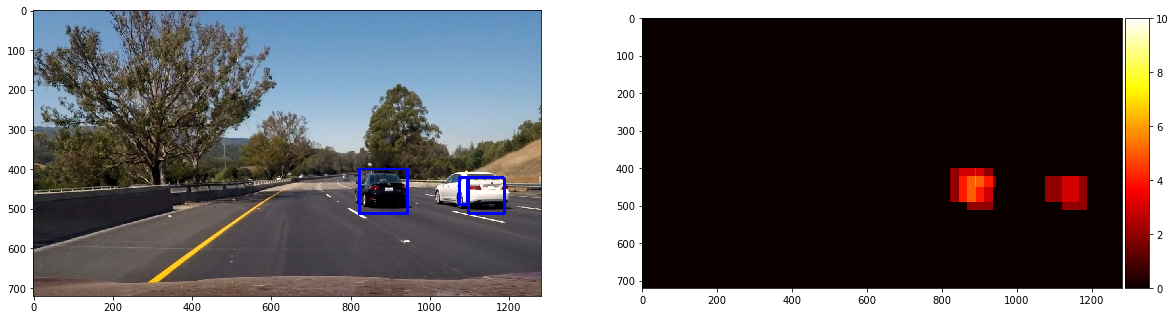

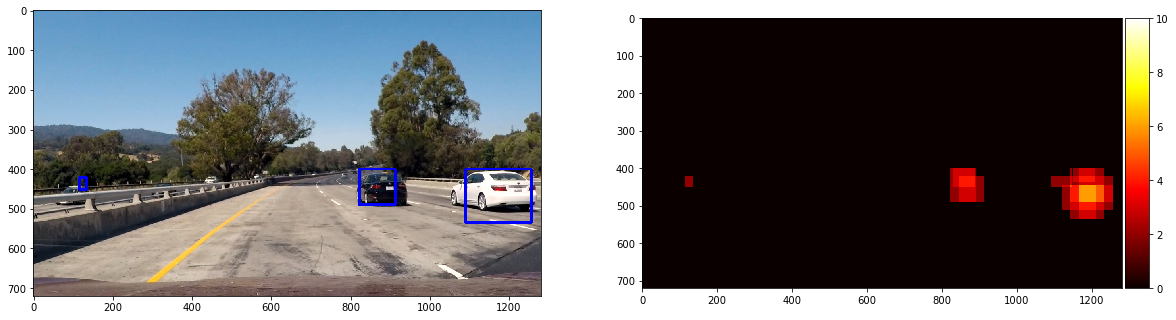

Prediction time for 6 images: 10.03


In [46]:
%lprun -f image_test image_test(verbose=True)

From above, we can see that the classifier is working pretty ok, but need some improvement.
The time required to run the classifier on one image is little less than .5 sec. 

## Tracking with video
### Load video

In [3]:
finder = VehicleFinder(color_space='YCrCb', spatial_size=(32,32), hist_nbins=32, hist_bins_range=(0,1.0), 
                       hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, channel=0)
finder.clf = joblib.load('./clf')
finder.scaler = joblib.load('./scaler')

In [7]:
#video = './project_video.mp4'
video = './test_video.mp4'
clip = VideoFileClip(video)

In [8]:
#finder = joblib.load('./finder')
clip_processed = clip.fl_image(finder.video_pipeline)

In [9]:
clip_processed.write_videofile('./result2.mp4', fps=30, audio=False)

[MoviePy] >>>> Building video ./result2.mp4
[MoviePy] Writing video ./result2.mp4



100%|██████████| 46/46 [00:24<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result2.mp4 

